In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [2]:
save_images = False
sep = ","
enc = "utf-8"
file = "correl_vs_gnn.csv"
df = pd.read_csv(file, sep=sep, header=0, encoding=enc)

In [3]:
def plot_alg_box(df, feat="OOA", suffixes=["GNN", "Correl"], ylabel=None,
        print_latex=False, ylim=None, figsize=(12,8), yticks=None, float_format="%.2f"):
    col_names = []
    title = feat
    for i in range(len(suffixes)):
        suffix = suffixes[i]
        col_name = feat + "_" + suffix
        col_names.append(col_name)
    sub_df = df.loc[:, col_names]
    
    if print_latex:
        df_desc = sub_df.describe(include="all")
        df_desc = df_desc.loc[["mean", "std", "25%", "50%", "75%"]]
        latex_str = df_desc.to_latex(escape=False, float_format=float_format)
        latex_str = latex_str.replace("_", "\_")
        latex_str = latex_str.replace("%", "\%")
        latex_str = latex_str.replace("|S|", "$|\mathcal{S}|$")
        
        print(latex_str)
    
    sub_df.plot(kind="box", figsize=figsize, rot=90, title=title, grid=True,
        showmeans=True, ylabel=ylabel, ylim=ylim, yticks=yticks)

\begin{tabular}{lrrrr}
\toprule
{} &  OOA\_GNN &  OOA\_Correl &  OOA\_Random &  OOA\_Imperfect \\
\midrule
mean &     0.78 &        0.74 &        0.74 &           0.75 \\
std  &     0.08 &        0.09 &        0.09 &           0.09 \\
25\%  &     0.73 &        0.69 &        0.69 &           0.70 \\
50\%  &     0.77 &        0.74 &        0.74 &           0.75 \\
75\%  &     0.83 &        0.80 &        0.80 &           0.81 \\
\bottomrule
\end{tabular}



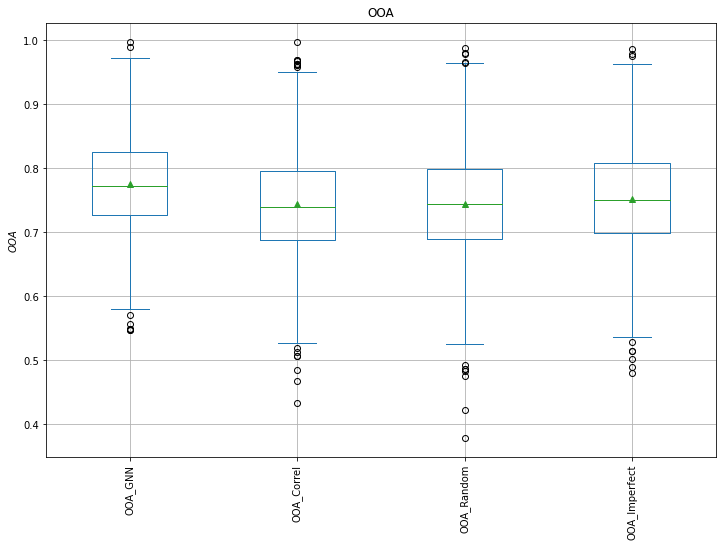

In [4]:
plot_alg_box(df=df, feat="OOA", ylabel=r"$OOA$", print_latex=True, suffixes=["GNN", "Correl", "Random", "Imperfect"])
if save_images:
    plt.savefig("correl_vs_gnn_ooa.png", bbox_inches="tight")

\begin{tabular}{lrrrr}
\toprule
{} &  $|\mathcal{S}|$\_GNN &  $|\mathcal{S}|$\_Correl &  $|\mathcal{S}|$\_Random &  $|\mathcal{S}|$\_Imperfect \\
\midrule
mean &   195.87 &      175.25 &      135.61 &         147.33 \\
std  &   115.88 &      104.32 &       83.48 &          89.69 \\
25\%  &   111.25 &       99.25 &       74.25 &          81.00 \\
50\%  &   170.50 &      153.00 &      117.00 &         128.50 \\
75\%  &   253.75 &      227.75 &      179.75 &         192.00 \\
\bottomrule
\end{tabular}



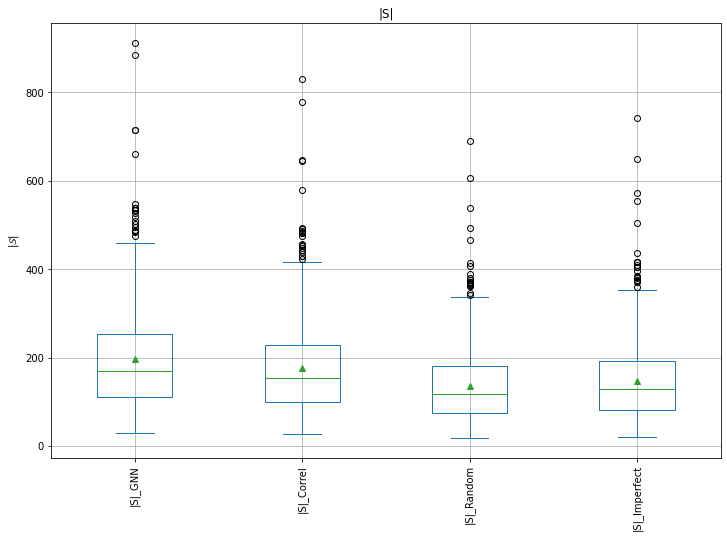

In [5]:
plot_alg_box(df=df, feat="|S|", ylabel=r"$|\mathcal{S}|$", print_latex=True, suffixes=["GNN", "Correl", "Random", "Imperfect"])
if save_images:
    plt.savefig("correl_vs_gnn_sizes.png", bbox_inches="tight")

\begin{tabular}{lrrrr}
\toprule
{} &  BCE\_GNN &  BCE\_Correl &  BCE\_Random &  BCE\_Imperfect \\
\midrule
mean &     0.65 &        0.80 &        1.00 &           0.04 \\
std  &     0.03 &        0.07 &        0.02 &           0.01 \\
25\%  &     0.63 &        0.76 &        0.99 &           0.03 \\
50\%  &     0.65 &        0.80 &        1.00 &           0.04 \\
75\%  &     0.67 &        0.85 &        1.02 &           0.04 \\
\bottomrule
\end{tabular}



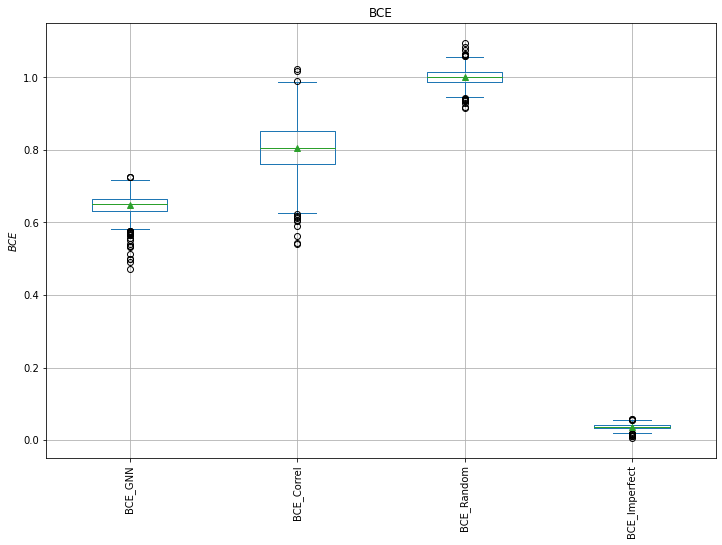

In [6]:
plot_alg_box(df=df, feat="BCE", ylabel=r"$BCE$", print_latex=True,
    suffixes=["GNN", "Correl", "Random", "Imperfect"], float_format="%.2f")
if save_images:
    plt.savefig("correl_vs_gnn_bce.png", bbox_inches="tight")

\begin{tabular}{lrrrr}
\toprule
{} &  MS\_GNN &  MS\_Correl &  MS\_Random &  MS\_Imperfect \\
\midrule
mean &  0.0019 &     0.0030 &     0.0092 &        0.0067 \\
std  &  0.0053 &     0.0097 &     0.0265 &        0.0195 \\
25\%  &  0.0001 &     0.0002 &     0.0005 &        0.0004 \\
50\%  &  0.0003 &     0.0005 &     0.0016 &        0.0012 \\
75\%  &  0.0010 &     0.0016 &     0.0052 &        0.0036 \\
\bottomrule
\end{tabular}



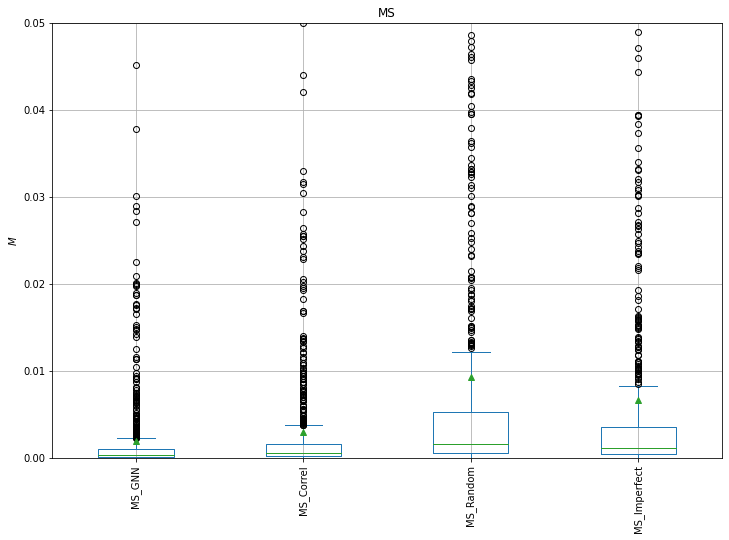

In [7]:
plot_alg_box(df=df, feat="MS", ylabel=r"$M$", print_latex=True,
    suffixes=["GNN", "Correl", "Random", "Imperfect"], float_format="%.4f",
            ylim=[0, 0.05])
if save_images:
    plt.savefig("correl_vs_gnn_bce.png", bbox_inches="tight")

\begin{tabular}{lrrrr}
\toprule
{} &  ACC\_GNN &  ACC\_Correl &  ACC\_Random &  ACC\_Imperfect \\
\midrule
mean &   0.6600 &      0.5995 &      0.4996 &         1.0000 \\
std  &   0.0665 &      0.0399 &      0.0116 &         0.0000 \\
25\%  &   0.6173 &      0.5723 &      0.4929 &         1.0000 \\
50\%  &   0.6578 &      0.5966 &      0.5000 &         1.0000 \\
75\%  &   0.7016 &      0.6240 &      0.5067 &         1.0000 \\
\bottomrule
\end{tabular}



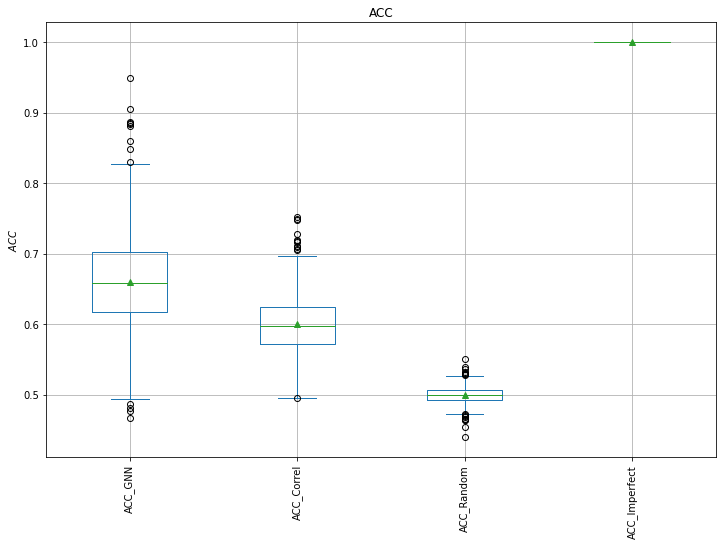

In [8]:
plot_alg_box(df=df, feat="ACC", ylabel=r"$ACC$", print_latex=True,
    suffixes=["GNN", "Correl", "Random", "Imperfect"], float_format="%.4f")
if save_images:
    plt.savefig("correl_vs_gnn_bce.png", bbox_inches="tight")

\begin{tabular}{lrrrr}
\toprule
{} &  F1\_GNN &  F1\_Correl &  F1\_Random &  F1\_Imperfect \\
\midrule
mean &  0.7932 &     0.6947 &     0.5672 &        1.0000 \\
std  &  0.0481 &     0.0431 &     0.0267 &        0.0000 \\
25\%  &  0.7633 &     0.6686 &     0.5515 &        1.0000 \\
50\%  &  0.7936 &     0.6953 &     0.5697 &        1.0000 \\
75\%  &  0.8246 &     0.7204 &     0.5840 &        1.0000 \\
\bottomrule
\end{tabular}



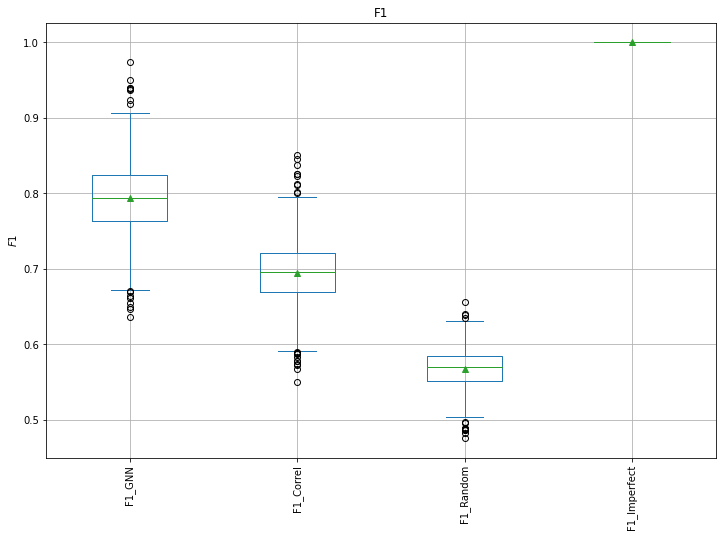

In [9]:
plot_alg_box(df=df, feat="F1", ylabel=r"$F1$", print_latex=True,
    suffixes=["GNN", "Correl", "Random", "Imperfect"], float_format="%.4f")
if save_images:
    plt.savefig("correl_vs_gnn_bce.png", bbox_inches="tight")

\begin{tabular}{lrrrr}
\toprule
{} &  PREC\_GNN &  PREC\_Correl &  PREC\_Random &  PREC\_Imperfect \\
\midrule
mean &    0.6604 &       0.6958 &       0.6604 &          1.0000 \\
std  &    0.0665 &       0.0636 &       0.0670 &          0.0000 \\
25\%  &    0.6192 &       0.6578 &       0.6179 &          1.0000 \\
50\%  &    0.6578 &       0.6952 &       0.6574 &          1.0000 \\
75\%  &    0.7021 &       0.7337 &       0.7024 &          1.0000 \\
\bottomrule
\end{tabular}



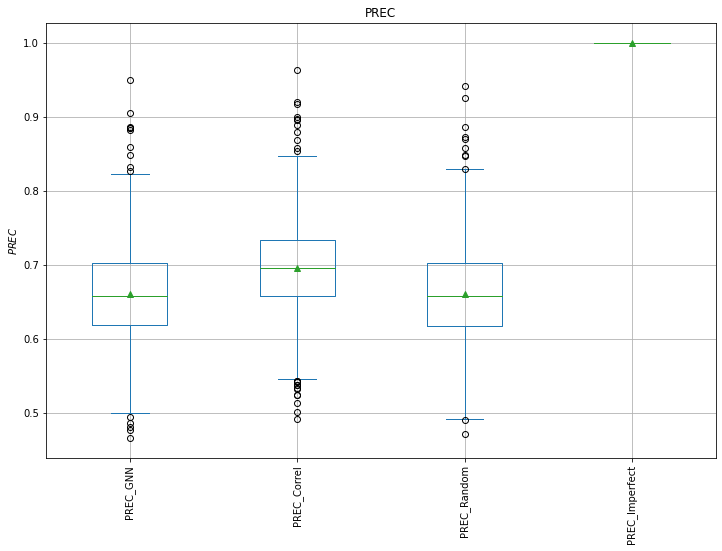

In [10]:
plot_alg_box(df=df, feat="PREC", ylabel=r"$PREC$", print_latex=True,
    suffixes=["GNN", "Correl", "Random", "Imperfect"], float_format="%.4f")
if save_images:
    plt.savefig("correl_vs_gnn_bce.png", bbox_inches="tight")

\begin{tabular}{lrrrr}
\toprule
{} &  REC\_GNN &  REC\_Correl &  REC\_Random &  REC\_Imperfect \\
\midrule
mean &   0.9988 &      0.6971 &      0.4994 &         1.0000 \\
std  &   0.0047 &      0.0461 &      0.0148 &         0.0000 \\
25\%  &   0.9996 &      0.6646 &      0.4907 &         1.0000 \\
50\%  &   1.0000 &      0.6966 &      0.4994 &         1.0000 \\
75\%  &   1.0000 &      0.7288 &      0.5090 &         1.0000 \\
\bottomrule
\end{tabular}



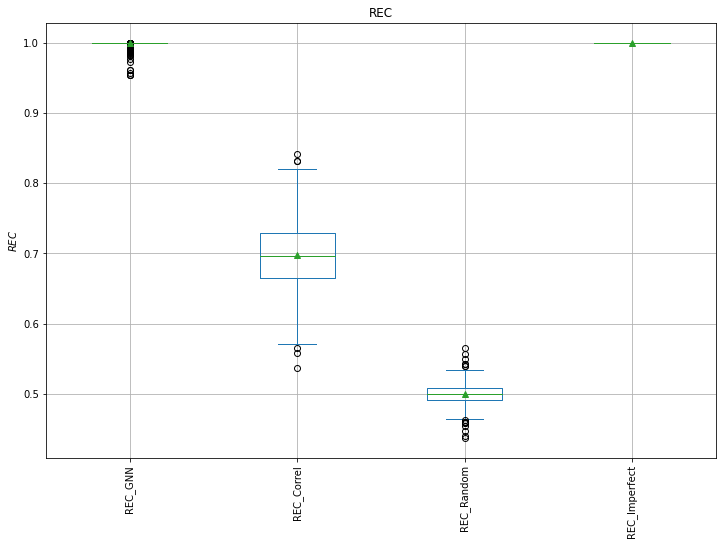

In [11]:
plot_alg_box(df=df, feat="REC", ylabel=r"$REC$", print_latex=True,
    suffixes=["GNN", "Correl", "Random", "Imperfect"], float_format="%.4f")
if save_images:
    plt.savefig("correl_vs_gnn_bce.png", bbox_inches="tight")

In [12]:
def outliers_idxs(arr):    
    q025 = np.quantile(a=arr, q=0.25, axis=0)
    q075 = np.quantile(a=arr, q=0.75, axis=0)
    iqr = q075 - q025
    lb = q025 - 1.5 * iqr
    ub = q075 + 1.5 * iqr
    mask = (arr >= ub) | (arr <= lb)
    out_rows = np.where(mask == True)[0]
    return out_rows


def ut_test(df, alpha=0.05, feat="OOA", suffixes=["GNN", "Correl"]):
    col_names = []
    title = feat
    print(title)
    if len(suffixes) != 2:
        raise Exception("Cannot apply u- or t-Test")
    for i in range(len(suffixes)):
        suffix = suffixes[i]
        col_name = feat + "_" + suffix
        col_names.append(col_name)
    sub_df = df.loc[:, col_names]
    
    idxs_0 = outliers_idxs(arr=sub_df[col_names[0]].to_numpy())
    idxs_1 = outliers_idxs(arr=sub_df[col_names[1]].to_numpy())
    out_idxs = np.vstack((idxs_0[:, None], idxs_1[:, None]))
    out_idxs = np.unique(out_idxs)
    print("Remove {0} outliers".format(out_idxs.shape[0]))
    remaining_idxs = np.arange(df.shape[0], dtype=np.uint32)
    remaining_idxs = np.delete(remaining_idxs, out_idxs)
    sub_df = sub_df.iloc[remaining_idxs, :]
    
    is_normal = True
    for i in range(len(col_names)):
        col_name = col_names[i]
        _, p_val = st.shapiro(sub_df[col_name])
        is_col_normal = p_val < alpha
        print("{0} is normal: {1} (p={2})".format(col_name, is_col_normal, p_val))
        is_normal = is_normal and is_col_normal
    _, p_val = st.bartlett(sub_df[col_names[0]], sub_df[col_names[1]])
    equal_var = p_val < alpha
    print("Equal variance: {0} (p={1})".format(equal_var, p_val))
    if is_normal and equal_var:
        _, p_val = st.ttest_ind(a=sub_df[col_names[0]], b=sub_df[col_names[1]])
        significant = p_val < alpha
        print("T-Test for {0} is significant: {1} (p={2:.5f})".format(title, significant, p_val))
    else:
        _, p_val = st.mannwhitneyu(x=sub_df[col_names[0]], y=sub_df[col_names[1]])
        significant = p_val < alpha
        print("U-Test for {0} is significant: {1} (p={2:.5f})".format(title, significant, p_val))

In [13]:
ut_test(df=df, feat="OOA")

OOA
Remove 19 outliers
OOA_GNN is normal: False (p=0.22634270787239075)
OOA_Correl is normal: True (p=0.007722827605903149)
Equal variance: True (p=0.001858408357419063)
U-Test for OOA is significant: True (p=0.00000)


In [14]:
ut_test(df=df, feat="|S|")

|S|
Remove 21 outliers
|S|_GNN is normal: True (p=1.2304995347309222e-13)
|S|_Correl is normal: True (p=1.0661850363084119e-13)
Equal variance: True (p=0.006908637576637582)
T-Test for |S| is significant: True (p=0.00006)


In [15]:
ut_test(df=df, feat="BCE")

BCE
Remove 31 outliers
BCE_GNN is normal: False (p=0.5013303756713867)
BCE_Correl is normal: False (p=0.31081146001815796)
Equal variance: True (p=1.087504910638461e-124)
U-Test for BCE is significant: True (p=0.00000)
